In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import gc
import cv2
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import tree

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model, Model

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
from utility.DataLoading import dataLoading
from utility.DataProcessing import dataProcessing
from utility.FileProcessing import fileProcessing
from utility.FindCuttingLine import findCuttingLine
from utility.Plotimage import plotimage, plot_hist
from utility.EstimatePerformance import estimatePerformance
from utility.ImageProcessing import imageProcessing
from utility.PredictDataHandler import predictDataHandler
from utility.PredictionRunners import predictionRunners

# Novelty and Outlier Detection
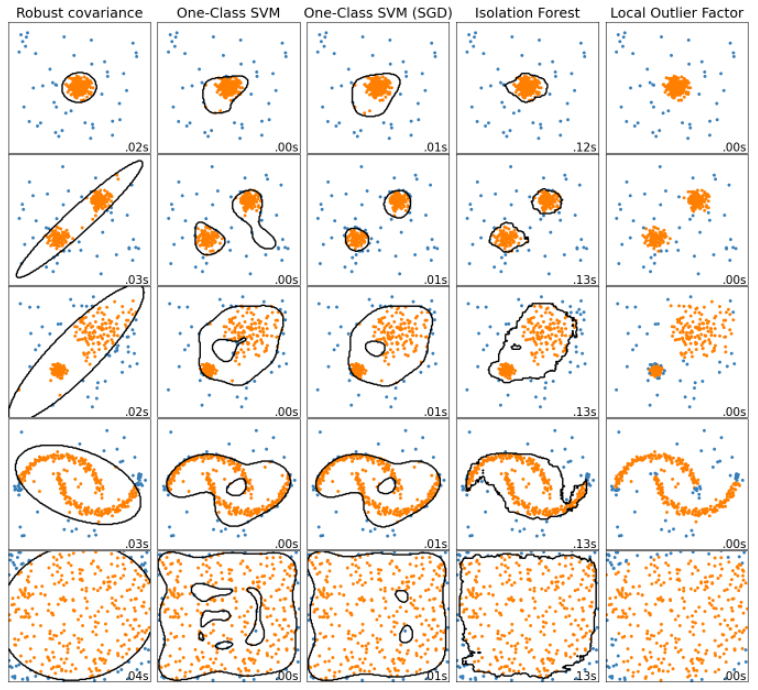
>https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html#sphx-glr-auto-examples-miscellaneous-plot-anomaly-comparison-py

> novelty detection & outlier detection : https://scikit-learn.org/stable/modules/outlier_detection.html

### Step1 基礎模型output features
### Step2 使用OK訓練集進行predition
### Step3 使用sklearn ML model學習決策邊界
### Step4 透過這個邊界去判別新的資料點是否與訓練數據類似，超出邊界即視為異常
 - 在 scikit-learn 提供 OneClass SVM 的說明頁面有提到：預測返回的 y 值為 1 代表正常 (inlier)，返回值為 -1 代表異常 ( outlier )

# 1. setup model and feature output

In [3]:
class restructurinModel:
    def __init__(self, model, model_output, new_output=[]):
        self.model = model
        self.model_output = model_output
        self.new_output  = new_output
    
    def base_model(self):
        return load_model(self.model)
        
    def restructuring(self):
        base_model=self.base_model()
        temp_model = Model(inputs=base_model.input, outputs=base_model.layers[self.model_output].output)
        x=temp_model.output
        predictions = Dense(self.new_output[0], self.new_output[1],name='dense_additional')(x) if self.new_output else x
        return Model(inputs=temp_model.input, outputs=predictions)

In [4]:
model_path='/tf/hsien/ai_rebin/COG_ai_rebin/DM_MF/2022-10-20_IRV2_multiclass/IRV2_multiclass_best_acc.h5'
dir_path=os.path.split(model_path)[0]+os.sep

In [5]:
strategy = tf.distribute.MirroredStrategy(cross_device_ops = tf.distribute.HierarchicalCopyAllReduce())
with strategy.scope():
    model=restructurinModel(model=model_path,model_output=-2).restructuring() #3,"sigmoid"

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

# 2. load dataset to extract layer(-2) features

In [6]:
config={
    'training_paths':[
        '/tf/cp1ai01/COG/03_POC訓練資料/DM/20221011/OK/Overkill',
        '/tf/cp1ai01/COG/03_POC訓練資料/MF/20221020/OK/Overkill',
    ],
    'test_paths':[
        '/tf/cp1ai01/COG/03_POC訓練資料/DM/test',
        '/tf/cp1ai01/COG/03_POC訓練資料/DM/考試卷',
        '/tf/cp1ai01/COG/03_POC訓練資料/MF/teat',
    ],
}

In [7]:
data_processor=dataProcessing(paths=config["training_paths"], split_symbol='-')

path=	 /tf/cp1ai01/COG/03_POC訓練資料/DM/20221011/OK/Overkill
已完成(累積)=	 41553
path=	 /tf/cp1ai01/COG/03_POC訓練資料/MF/20221020/OK/Overkill
已完成(累積)=	 105514
                                            fullPath  \
0  /tf/cp1ai01/COG/03_POC訓練資料/DM/20221011/OK/Over...   
1  /tf/cp1ai01/COG/03_POC訓練資料/DM/20221011/OK/Over...   
2  /tf/cp1ai01/COG/03_POC訓練資料/DM/20221011/OK/Over...   
3  /tf/cp1ai01/COG/03_POC訓練資料/DM/20221011/OK/Over...   
4  /tf/cp1ai01/COG/03_POC訓練資料/DM/20221011/OK/Over...   
5  /tf/cp1ai01/COG/03_POC訓練資料/DM/20221011/OK/Over...   
6  /tf/cp1ai01/COG/03_POC訓練資料/DM/20221011/OK/Over...   
7  /tf/cp1ai01/COG/03_POC訓練資料/DM/20221011/OK/Over...   
8  /tf/cp1ai01/COG/03_POC訓練資料/DM/20221011/OK/Over...   
9  /tf/cp1ai01/COG/03_POC訓練資料/DM/20221011/OK/Over...   

                                    fileName path-0 path-1   path-2 path-3  \
0    DM74D1-R27DMGW-001-(+0065+0006)-010.JPG            tf  cp1ai01    COG   
1    DM74D1-R27DMGW-001-(+0085+0000)-016.JPG            tf  cp1ai01    COG   


classes_dic=	 {'OK': 0}
classes_dic_reverse=	 {0: 'OK'}
total=
 OK    105514
Name: class, dtype: int64


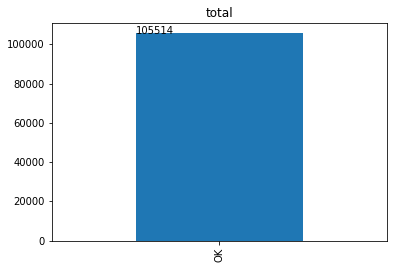

,fullPath,fileName,class,defect
0,/tf/cp1ai01/COG/03_POC訓練資料/DM/20221011/OK/Over...,DM74D1-R27DMGW-001-(+0065+0006)-010.JPG,OK,Overkill
1,/tf/cp1ai01/COG/03_POC訓練資料/DM/20221011/OK/Over...,DM74D1-R27DMGW-001-(+0085+0000)-016.JPG,OK,Overkill
2,/tf/cp1ai01/COG/03_POC訓練資料/DM/20221011/OK/Over...,DM74D1-R27DMGW-001-(+0104+0001)-018.JPG,OK,Overkill
3,/tf/cp1ai01/COG/03_POC訓練資料/DM/20221011/OK/Over...,DM74D1-R27DMGW-001-(+0105+0000)-019.JPG,OK,Overkill
4,/tf/cp1ai01/COG/03_POC訓練資料/DM/20221011/OK/Over...,DM74D1-R27DMGW-002-(+0088+0005)-005.JPG,OK,Overkill
...,...,...,...,...
105509,/tf/cp1ai01/COG/03_POC訓練資料/MF/20221020/OK/Over...,MFVG4-R34MFKV-010-(+0310+0004)-017.JPG,OK,Overkill
105510,/tf/cp1ai01/COG/03_POC訓練資料/MF/20221020/OK/Over...,MFU4FB5CNA-R29MFKR-037-(+0179+0001)-008.JPG,OK,Overkill
105511,/tf/cp1ai01/COG/03_POC訓練資料/MF/20221020/OK/Over...,MF47HUNUCD3-R33MFLG-033-(+0006+0010)-148.JPG,OK,Overkill
105512,/tf/cp1ai01/COG/03_POC訓練資料/MF/20221020/OK/Over...,MFU2SJ2-R35MFNN-013-(+0298+0004)-455.JPG,OK,Overkill


In [8]:
cols={
    'fullPath':'fullPath',
    'fileName':'fileName',
    'path-7':'class',
    'path-8':'defect',
     }
dftrain=data_processor.setup_columns(col_dict=cols, class_col='class' ,class_col_replace={})
classes_dic=data_processor.classes_dic
classes_dic_reverse=data_processor.classes_dic_reverse
dftrain

In [9]:
data_processor=dataProcessing(paths=config["test_paths"], split_symbol='-')

path=	 /tf/cp1ai01/COG/03_POC訓練資料/DM/test
已完成(累積)=	 14867
path=	 /tf/cp1ai01/COG/03_POC訓練資料/DM/考試卷
已完成(累積)=	 16093
path=	 /tf/cp1ai01/COG/03_POC訓練資料/MF/teat
已完成(累積)=	 16093
                                            fullPath  \
0  /tf/cp1ai01/COG/03_POC訓練資料/DM/test/NG/FM/DMZCB...   
1  /tf/cp1ai01/COG/03_POC訓練資料/DM/test/NG/FM/DMASA...   
2  /tf/cp1ai01/COG/03_POC訓練資料/DM/test/NG/FM/DMAPA...   
3  /tf/cp1ai01/COG/03_POC訓練資料/DM/test/NG/FM/DMW1C...   
4  /tf/cp1ai01/COG/03_POC訓練資料/DM/test/NG/FM/DMAPA...   
5  /tf/cp1ai01/COG/03_POC訓練資料/DM/test/NG/FM/DMW1C...   
6  /tf/cp1ai01/COG/03_POC訓練資料/DM/test/NG/FM/DMZAD...   
7  /tf/cp1ai01/COG/03_POC訓練資料/DM/test/NG/FM/DMOMD...   
8  /tf/cp1ai01/COG/03_POC訓練資料/DM/test/NG/FM/DMZ3B...   
9  /tf/cp1ai01/COG/03_POC訓練資料/DM/test/NG/FM/DMBDA...   

                                  fileName path-0 path-1   path-2 path-3  \
0  DMZCB3-R28DMMJ-028-(+0179+0006)-018.JPG            tf  cp1ai01    COG   
1  DMASA1-RA2DMBH-027-(+0092+0005)-005.JPG            tf  

classes_dic=	 {'OK': 0, 'NG': 1}
classes_dic_reverse=	 {0: 'OK', 1: 'NG'}
total=
 OK    9977
NG    6116
Name: class, dtype: int64


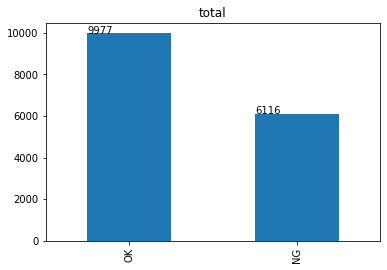

,fullPath,fileName,class,defect
0,/tf/cp1ai01/COG/03_POC訓練資料/DM/test/NG/FM/DMZCB...,DMZCB3-R28DMMJ-028-(+0179+0006)-018.JPG,NG,FM
1,/tf/cp1ai01/COG/03_POC訓練資料/DM/test/NG/FM/DMASA...,DMASA1-RA2DMBH-027-(+0092+0005)-005.JPG,NG,FM
2,/tf/cp1ai01/COG/03_POC訓練資料/DM/test/NG/FM/DMAPA...,DMAPA1-R27DMQE-004-(+0196+0006)-005.JPG,NG,FM
3,/tf/cp1ai01/COG/03_POC訓練資料/DM/test/NG/FM/DMW1C...,DMW1C4-R28DMKJ-013-(+0043+0003)-004.JPG,NG,FM
4,/tf/cp1ai01/COG/03_POC訓練資料/DM/test/NG/FM/DMAPA...,DMAPA1-R27DMJX-036-(+0145+0006)-003.JPG,NG,FM
...,...,...,...,...
16088,/tf/cp1ai01/COG/03_POC訓練資料/DM/考試卷/OK/Chipping/...,DMZRE2-R40DMJK-012-(+0127+0004)-009.JPG,OK,Chipping
16089,/tf/cp1ai01/COG/03_POC訓練資料/DM/考試卷/OK/Chipping/...,DMZRE2-R40DMJK-013-(+0061+0005)-001.JPG,OK,Chipping
16090,/tf/cp1ai01/COG/03_POC訓練資料/DM/考試卷/OK/Chipping/...,DMZRE2-R40DMJK-013-(+0105+0004)-010.JPG,OK,Chipping
16091,/tf/cp1ai01/COG/03_POC訓練資料/DM/考試卷/OK/Chipping/...,DMZRE2-RL0DMD5-003-(+0059+0000)-006.JPG,OK,Chipping


In [10]:
cols={
    'fullPath':'fullPath',
    'fileName':'fileName',
    'path-7':'class',
    'path-8':'defect',
     }
dftest=data_processor.setup_columns(col_dict=cols, class_col='class' ,class_col_replace={})
classes_dic=data_processor.classes_dic
classes_dic_reverse=data_processor.classes_dic_reverse
dftest

In [11]:
print('dftrain : ',dftrain.shape)
print('dftest : ',dftest.shape)

dftrain :  (105514, 4)
dftest :  (16093, 4)


In [29]:
testX = dataLoading(channel=1, paths=dftest['fullPath'].values).output_X
print('testX : ',testX.shape)

testX :  (16093, 224, 224)


In [30]:
trainX = dataLoading(channel=1, paths=dftrain['fullPath'].values).output_X
print('trainX : ',trainX.shape)

trainX :  (105514, 224, 224)


In [32]:
train_feature = model.predict(trainX, batch_size=128)
train_feature.shape

(105514, 512)

In [33]:
test_feature = model.predict(testX, batch_size=128)
test_feature.shape

(16093, 512)

# 3. Sklearn - Novelty and Outlier Detection

### "Robust_covariance"
### "One-Class_SVM"
### "Isolation_Forest"
### "Local_Outlier_Factor"

 -  nu : 
 `透過 unsupervised learning 的方式極小化正常樣本與邊界的距離，因此邊界如何定義就是 nu 這個參數（介於 0~1的比率）在控制的事情。舉例：nu =0.1，代表了：正常樣本卻誤判為異常的最多不超過 10% （以本範例來說，200 個樣本當中，被判為異常的要不超過 20 個 ）；至少要有正常樣本的 10%（也就是 20 個）作為衡量與邊界 margin 的 support vectors。`

 - gamma : 
 `代表了 RBF Kernel 將樣本投影到高維空間的縮放比例，gamma 值設定的越小代表樣本在高維空間的越分散，即 𝜎 越大，在訓練時的作用可能會造成準確率較低，但預測未知樣本的泛化能力強；反之 gamma 值設定的越大，樣本在高維空間會擠在一起，所獲得的 support vectors 就會較少，訓練時準確率較高，但預測未知的泛化能力弱。`

In [37]:
outliers_fraction=0.3

In [51]:
anomaly_algorithms = [
#     ("Robust_covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class_SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma='auto')),
#     ("Isolation_Forest",IsolationForest(contamination=outliers_fraction, random_state=4)),
#     ("Local_Outlier_Factor",LocalOutlierFactor(contamination=outliers_fraction)),
]

In [ ]:
for name, algorithm in anomaly_algorithms:
    try :
        # model fit
        print(name,'訓練中...')
        t0 = time.time()
        ML_model=algorithm.fit(train_feature)
        t1 = time.time()
        print('訓練共耗時:',round((t1 - t0), 2), '秒')
        
        ''' model save
        pickle.dump(ML_model, open(filename, 'wb'))
        loaded_model = pickle.load(open(filename, 'rb'))
        
        '''
        # save model
        if not os.path.isdir(f'ML_model/{name}'):
            os.makedirs(f'ML_model/{name}')
        filename = f'ML_model/{name}/{name}_nu-{outliers_fraction}-1024.sav'
        pickle.dump(ML_model, open(filename, 'wb'))
        print('model_save:',filename)
        
        # model test
        print(name,'測試中...')
        t3 = time.time()
        if name == "Local_Outlier_Factor":
            pred_test = ML_model.fit_predict(test_feature)
        else:
            pred_test = ML_model.predict(test_feature)
        t4 = time.time()
        print('測試共耗時:',round((t4 - t3), 2), '秒')

        unique, counts = np.unique(pred_test, return_counts=True)
        print(dict(zip(unique, counts)))
        
        # save test result
        dftest[name]=pred_test
        
        print('----------------------------------------------------------------------------------')
        
    except Exception as e:
            print(e)
            
dftest.to_excel(f'ML_model/result-nu-0.3-1031.xlsx')

One-Class_SVM 訓練中...


## 3-1 `outliers_fraction` 參數最佳化

In [47]:
outliers_f_list=[0.1,0.2,0.3,0.4,0.5]
for f in outliers_f_list:
    name=f'Isolation_Forest_nu-{f}'
    try :
        # model fit
        print(name,'訓練中...')
        t0 = time.time()
        model=IsolationForest(contamination=f, random_state=42)
        ML_model=model.fit(train_feature)
        t1 = time.time()
        print('訓練共耗時:',round((t1 - t0), 2), '秒')
        
        ''' model save
        pickle.dump(ML_model, open(filename, 'wb'))
        loaded_model = pickle.load(open(filename, 'rb'))
        
        '''
        # save model
        if not os.path.isdir(f'ML_model/{name}'):
            os.makedirs(f'ML_model/{name}')
        filename = f'ML_model/{name}/{name}_nu-{outliers_fraction}-1024.sav'
        pickle.dump(ML_model, open(filename, 'wb'))
        print('model_save:',filename)
        
        # model test
        print(name,'測試中...')
        t3 = time.time()
        if name == "Local_Outlier_Factor":
            pred_test = ML_model.fit_predict(test_feature)
        else:
            pred_test = ML_model.predict(test_feature)
        t4 = time.time()
        print('測試共耗時:',round((t4 - t3), 2), '秒')

        unique, counts = np.unique(pred_test, return_counts=True)
        print(dict(zip(unique, counts)))
        
        # save test result
        dftest[name]=pred_test
        
        print('----------------------------------------------------------------------------------')
        
    except Exception as e:
            print(e)
            
dftest.to_excel(f'ML_model/result-Isolation_Forest-0.1to0.5-1031.xlsx')

Isolation_Forest_nu-0.1 訓練中...
訓練共耗時: 85.26 秒
model_save: ML_model/Isolation_Forest_nu-0.1/Isolation_Forest_nu-0.1_nu-0.2-1024.sav
Isolation_Forest_nu-0.1 測試中...
測試共耗時: 1.74 秒
{-1: 11650, 1: 4443}
----------------------------------------------------------------------------------
Isolation_Forest_nu-0.2 訓練中...
訓練共耗時: 83.72 秒
model_save: ML_model/Isolation_Forest_nu-0.2/Isolation_Forest_nu-0.2_nu-0.2-1024.sav
Isolation_Forest_nu-0.2 測試中...
測試共耗時: 1.62 秒
{-1: 12117, 1: 3976}
----------------------------------------------------------------------------------
Isolation_Forest_nu-0.3 訓練中...
訓練共耗時: 83.76 秒
model_save: ML_model/Isolation_Forest_nu-0.3/Isolation_Forest_nu-0.3_nu-0.2-1024.sav
Isolation_Forest_nu-0.3 測試中...
測試共耗時: 1.61 秒
{-1: 12543, 1: 3550}
----------------------------------------------------------------------------------
Isolation_Forest_nu-0.4 訓練中...
訓練共耗時: 83.78 秒
model_save: ML_model/Isolation_Forest_nu-0.4/Isolation_Forest_nu-0.4_nu-0.2-1024.sav
Isolation_Forest_nu-0.4 測試中..

## 4. Gaussian Mixture Model
>[不到50行程式讓-ai-幫你偵測異常資料] https://medium.com/ai-academy-taiwan/%E4%B8%8D%E5%88%B050%E8%A1%8C%E7%A8%8B%E5%BC%8F%E8%AE%93-ai-%E5%B9%AB%E4%BD%A0%E5%81%B5%E6%B8%AC%E7%95%B0%E5%B8%B8%E8%B3%87%E6%96%99-abe828addbeb

>https://towardsdatascience.com/understanding-anomaly-detection-in-python-using-gaussian-mixture-model-e26e5d06094b

In [131]:
gmm = GaussianMixture(n_components=1)
gmm.fit(x_feature)

GaussianMixture()

In [132]:
OKscore = gmm.score_samples(x_feature)

In [133]:
thred = OKscore.mean() - 3 * OKscore.std()
thred

205.99238033847269

In [134]:
score = gmm.score_samples(test_feature)

In [138]:
score_class = score.copy()
score_class = np.where(score_class>thred,1, -1)
dftest_data['GaussianMixture_score']=score
dftest_data['GaussianMixture']=score_class

array([-1,  1,  1, ...,  1, -1,  1])

In [141]:
table=pd.pivot_table(dftest_data,index=['GaussianMixture'],columns=['GT','class'],values=["path"],aggfunc='count',fill_value=0)
underkill_cnt=table.iloc[1, table.columns.get_level_values(1)=='NG'].sum()
total=dftest_data.shape[0]
print('--------------------------------------------------------------------------------')
print('**','GaussianMixture')
print(table)
print(f'underkill(%) = {underkill_cnt*100/total} %')
print(f'underkill(ppm,*1%) = {(underkill_cnt/total)*0.01*10**6} ppm')

--------------------------------------------------------------------------------
** GaussianMixture
                path                                               
GT                NG                          OK                   
class           IC斷裂 切割道 刮傷 掉Bump    異物 護缺   切割道  刮傷   異物    誤判  護缺
GaussianMixture                                                    
-1                 4   9  8   382  3275  2   142  84  988    40  20
 1                 1   0  1     0    89  0  2366   3   60  2518   8
underkill(%) = 0.91 %
underkill(ppm,*1%) = 91.0 ppm


(-10000.0, 2000.0)

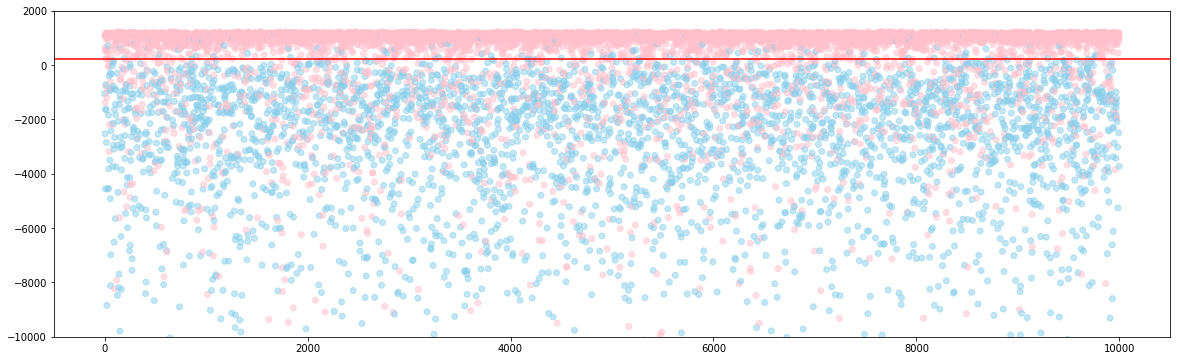

In [163]:
plt.figure(figsize=(20,6))
plt.scatter(range(len(score)), score, alpha=0.5, c=['skyblue' if x == 'NG' else 'pink' for x in dftest_data['GT'].values.tolist()])
plt.axhline(y=thred, color='r', linestyle='-')
plt.ylim(-10000, 2000)

In [177]:
gmm_result=pd.DataFrame({'score': score, 'GT': dftest_data['GT'].values, 'class': dftest_data['class'].values})

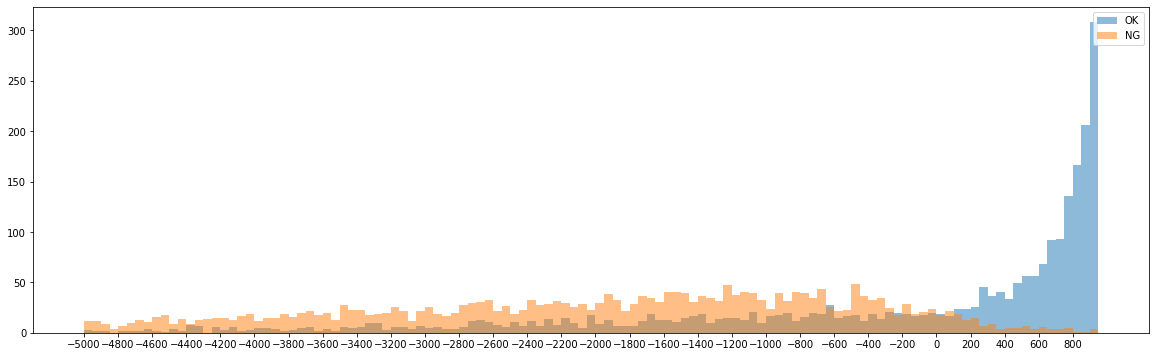

In [199]:
plt.figure(figsize=(20,6))
bins_range=np.arange(-5000, 1000, 50)
plt.hist(gmm_result[gmm_result['GT']=="OK"].score, alpha=0.5, bins=bins_range, label='OK')
plt.hist(gmm_result[gmm_result['GT']=="NG"].score, alpha=0.5, bins=bins_range, label='NG')
plt.legend(loc='upper right')
plt.xticks(np.arange(-5000, 1000, 200))
plt.show()

In [208]:
for i in range(300, 1000, 50):
    df_underkill=gmm_result[(gmm_result['score']>i)&(gmm_result['GT']=='NG')]
    underkill_cnt=df_underkill.shape[0]
    total=gmm_result.shape[0]
    print(f'underkill(ppm,*1%,thred={i}) = {round((underkill_cnt/total)*0.01*10**6,0)} ppm')

underkill(ppm,*1%,thred=300) = 70.0 ppm
underkill(ppm,*1%,thred=350) = 61.0 ppm
underkill(ppm,*1%,thred=400) = 57.0 ppm
underkill(ppm,*1%,thred=450) = 52.0 ppm
underkill(ppm,*1%,thred=500) = 47.0 ppm
underkill(ppm,*1%,thred=550) = 40.0 ppm
underkill(ppm,*1%,thred=600) = 36.0 ppm
underkill(ppm,*1%,thred=650) = 30.0 ppm
underkill(ppm,*1%,thred=700) = 26.0 ppm
underkill(ppm,*1%,thred=750) = 22.0 ppm
underkill(ppm,*1%,thred=800) = 17.0 ppm
underkill(ppm,*1%,thred=850) = 16.0 ppm
underkill(ppm,*1%,thred=900) = 15.0 ppm
underkill(ppm,*1%,thred=950) = 11.0 ppm
